# IPyTracker
Jupyter Notebook to perform circle detection, tracking, and analysis.

In [4]:
from ipywidgets import Video, Image, FloatSlider, IntSlider, Button, Output, VBox, interact
from IPython.display import display
from dataclasses import dataclass, fields
from datetime import timedelta, datetime
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import time
import os
import cv2
import ffmpeg
import csv
import math
import warnings
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning) # avoid installing pyarrow because it is huge
import pandas as pd

## Filename Generation
It is important to be structured when organizing and naming data/files. This will obviously allow you to work more efficiently. But above all, it allows you to scale up your research easily. Below function helps by generating a path that you can save your different files to. You can edit it to suit your own needs and preferences.

In [5]:
def get_unique_filename():
    # make directory if necessary
    if not os.path.exists('data'):
        print('creating data directory')
        os.makedirs('data')
        
    # append timestamp and unique number to filename
    name = 'data/recording_' + datetime.now().strftime('%m%d_%I:%M')
    filenumber = 0
    while os.path.isfile(name + str(filenumber).zfill(3) + '.h264'):
        filenumber += 1
    return name + '_' + str(filenumber).zfill(3)

path = get_unique_filename()

## Single Image Capture
The below cell captures, saves, and displays a single image. You might find this useful for positioning your camera correctly. Alternatively, use a program of your own choice to display a preview window.

In [6]:
# path to write image to
global path
still_path = path + '.png'

# capture image
os.system(f'libcamera-still --width 768 --height 432 --immediate -n -e png -o {still_path} 2>/dev/null')

# display image
img = Image.from_file(still_path)
img

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x00\x00\x00\x01\xb0\x08\x02\x00\x00\x00\x91\xb6\…

## Video Capture
Below cell captures video, converts it to the mp4 format, and displays it in a loop. Additionally, timestamps are also saved per frame.

In [8]:
global path

# video capture/global settings
video_path = path             # no file extension in path so it is reusable
length = 10000                # video capture duration in milliseconds
focus = 0.75                  # lens distance to focus point in meters
width = 768                   # frame width
height = 432                  # frame height
shutter = 750                 # exposure time in microseconds
gain = 1.5                    # gain to apply to image
fps = 100                     # capture framerate

# specify options for video recording
flags = f'--width {width} --height {height} --shutter {shutter} -t {length} -n --gain {gain} --denoise cdn_off --level 4.2 --framerate {fps} --autofocus-mode manual --lens-position {1 / focus}'

# capture video
os.system('echo "starting video capture"')
os.system(f'libcamera-vid {flags} --save-pts {video_path}.pts -o {video_path}.h264 -n 2>/dev/null')

# convert .h264 to .mp4
os.system('echo "starting video conversion"')
os.system(f'ffmpeg -y -i {video_path}.h264 {video_path}.mp4 2>/dev/null')

# display video
vid = Video.from_file(f'{video_path}.mp4')
vid

starting video capture
starting video conversion


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\x8a[mdat\x00\x…

## Single Frame Selection
This cell allows you to select a single frame from your video. This can be very useful in order to finetune your configuration for the circle detection algorithm. Again, use any other tool if this is not your preferred method.
Hint: single-click the slider and use the arrow keys for precise scrolling.

In [9]:
global path

# path to source video
video_path = path + '.mp4'

# path to write selected frame to
frame_path = path + '.png'

# our image byte array
img = np.ndarray((1,1,1))

# calculate number of frames in video
cap = cv2.VideoCapture(video_path)
nr_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# ui elements
slider = FloatSlider(min=0, max=1.0, step=0.005)
button = Button(description='Save Frame')
out = Output()
display(slider, button)

# gets called each time slider value changes
def slider_callback(change):
    global img
    with out:
        out.clear_output()
        frame_nr = int(change['new'] * nr_frames)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr)
        ret, img = cap.read()
        if ret:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.axis('off')
            plt.imshow(img)
            plt.tight_layout()
            plt.show()

# gets called each time button gets pressed
def button_callback(_):
    global img
    with out:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(frame_path, img)
        print('image saved')
    

# register callback functions
slider.observe(slider_callback, names='value')
button.on_click(button_callback)

# display callback output
out

FloatSlider(value=0.0, max=1.0, step=0.005)

Button(description='Save Frame', style=ButtonStyle())

Output()

## Circle Detection Algorithm
The actual circle detection algorithm. For more info on the meaning of the config fields, please refer to the openCV documentation.
Right now, this only function only returns a marked image. CSV ouput will be added in the future.

In [10]:
# sharpening kernel
kernel = np.array([ \
    [0, -1, 0],     \
    [-1, 5, -1],    \
    [0, -1, 0]      \
])

# hough detection configuration
@dataclass
class HoughConfig:
    min_dist: int = 10
    hi_thresh: int = 50
    acc_thresh: int = 30
    min_radius: int = 10
    max_radius: int = 0
    preprocessing_thresh: int = 80

# circle detector returns found circle positions
# or an image with markings on circles if in debug mode
def track_objects(img, conf, debug=False):
    # preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    sharp = cv2.filter2D(blur, -1, kernel)
    _, thresh = cv2.threshold(sharp, conf.preprocessing_thresh, 255, cv2.THRESH_BINARY)

    # detect circles
    circles = cv2.HoughCircles(                               \
        thresh, cv2.HOUGH_GRADIENT, 1, conf.min_dist,         \
        param1=conf.hi_thresh, param2=conf.acc_thresh,        \
        minRadius=conf.min_radius, maxRadius=conf.max_radius  \
    ) 
    if not debug:
        return circles  # can be None
    if circles is None:
        return thresh   # no circles to draw

    # draw circles
    circles = np.uint16(np.around(circles))
    res = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    for i in circles[0,:]:
        cv2.circle(res, (i[0],i[1]), i[2], (0,255,0), 2)
        cv2.circle(res, (i[0],i[1]), 2, (0,0,255), 3)
    return res

## Detection Configuration
Using the sliders from the cell below, you can create a configuration for the detection algorithm to suit your specific needs. Of course, your configuration is restricted to a certain domain using only these 6 parameters. Luckily, openCV provides a lot of documentation and tutorials, so don't be afraid to get your hands dirty!

In [11]:
# path to read selected frame from
global frame_path

# create a default configuration
config = HoughConfig()

# gets called each time a slider value changes
def slider_callback(change):
    global img
    with out:
        out.clear_output()
        # update config
        setattr(config, change.owner.description, change.new)
        
        # apply tracking
        unmarked = cv2.imread(frame_path)
        marked = track_objects(unmarked, config, True)
        marked = cv2.cvtColor(marked, cv2.COLOR_BGR2RGB)
        
        # show image
        plt.axis('off')
        plt.imshow(marked)
        plt.tight_layout()
        plt.show()

# gets called each time button gets pressed
def button_callback(_):
    for s, f in zip(sliders, fields(HoughConfig)):
        setattr(config, field.name, s.value)
    with out:
        out.clear_output()
        print('Config Updated')
        
# ui elements
sliders = []
button = Button(description='Save Config')

# TODO: fix proper range per slider
# one slider for each field in our config
for field in fields(HoughConfig):
    # create slider
    slider = IntSlider(
        value=getattr(config, field.name),
        min=0,
        max=100,  # Adjust max value as needed
        step=1,
        description=field.name
    )
    # Register the callback with each slider
    slider.observe(slider_callback, 'value')
    sliders.append(slider)

# register button callback
button.on_click(button_callback)

out = Output()
display(VBox(sliders), button)

# display callback output
out

Button(description='Save Config', style=ButtonStyle())

Output()

## Cache Frames
Get array of frames for processing convenience.
NB: This caches the entire video; try to keep your recordings as short as possible

In [12]:
global path

# let ffmpeg write raw video to pipe
out, _ = (
    ffmpeg
    .input(path + '.h264')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)

# capture from pipe
video = (
    np
    .frombuffer(out, dtype=np.uint8)
    .reshape([-1, height, width, 3])
)
print('done')

ffmpeg version 5.1.4-0+rpt1+deb12u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+rpt1+deb12u1 --toolchain=hardened --incdir=/usr/include/aarch64-linux-gnu --enable-gpl --disable-stripping --disable-mmal --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-

done


frame=  937 fps=172 q=-0.0 Lsize=  910764kB time=00:00:09.37 bitrate=796262.4kbits/s speed=1.72x    
video:910764kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%


## Pixel to Real Distance Conversion
This conversion assumes that every point of interest is located on the plane on which the camera is focused.

In [13]:
# these values are specific to this camera; do not change them unless using a different camera
horizontal_fov = 66 * math.pi / 180
vertical_fov = 41 * math.pi / 180

# camera distance to plane in meters; verify this yourself!
camera_dist = 0.75

# physical dimensions of our frame
frame_width = math.tan(horizontal_fov / 2) * camera_dist
frame_height = math.tan(vertical_fov / 2) * camera_dist

# convert given pixel coordinates to real world; uses upper-left corner as origin
def pixel_to_real_distance(x, y):
    global width, height
    return x / width * frame_width, y / height * frame_height

## Frame Sanitization and Tracking
In this cell it is possible to gather tracking information for each frame of the video that gets cached above. By default, a subset of all frames that contain tracking points will be collected. This subset will then be made available for further manual cleanup. 

In [14]:
global config
global path

# metadata class for tracked objects in frames
@dataclass
class TrackingPoint:
    delta: timedelta = timedelta(0)
    frame_index: int = 0
    pixel_pos: (int, int) = (0, 0)
    real_pos: (int, int) = (0, 0)

tracking_points = []

# fetch timestamps from recording
with open(path + '.pts') as file:
    timestamps = file.readlines()[1:]

# get metadata for each frame where objects were detected
for i, frame in enumerate(video):
    circles = track_objects(frame, config)
    if circles is not None:
        for c in circles:
            p = TrackingPoint()
            p.delta = timedelta(milliseconds=float(timestamps[i]))
            p.frame_index = i
            p.pixel_pos = (c[0][0], c[0][1])
            p.real_pos = (pixel_to_real_distance(c[0][0], c[0][1]))
            tracking_points.append(p)

# get a subset of frames which has only non-empty frames
frame_subset = []
for p in tracking_points:
    frame_subset.append(video[p.frame_index])
nr_frames = len(frame_subset)

# ui elements
slider = IntSlider(min=0, max=nr_frames - 1, step=1, readout=True)
button = Button(description='Remove Frame')
out = Output()
display(slider, button)

# gets called each time slider value changes
def slider_callback(change):
    with out:
        out.clear_output()
        plt.axis('off')
        plt.imshow(frame_subset[change['new']])
        plt.tight_layout()
        plt.show()

# gets called each time button gets pressed
def button_callback(_):
    frame_subset.pop(slider.value)
    tracking_points.pop(slider.value)
    slider.max -= 1
    slider_callback({ 'new': slider.value })

# register callback functions
slider.observe(slider_callback, names='value')
button.on_click(button_callback)

# display callback output
out

IntSlider(value=0, max=40)

Button(description='Remove Frame', style=ButtonStyle())

Output()

## Data Export
This cell converts the list of tracking points created earlier to csv data, and writes it to disk

,time,x_pos,y_pos
0,4791.741,0.233064,0.020447
1,4801.724,0.233698,0.043166
2,4811.707,0.233064,0.066533
3,4821.690,0.234966,0.090550
4,4841.654,0.234332,0.142479


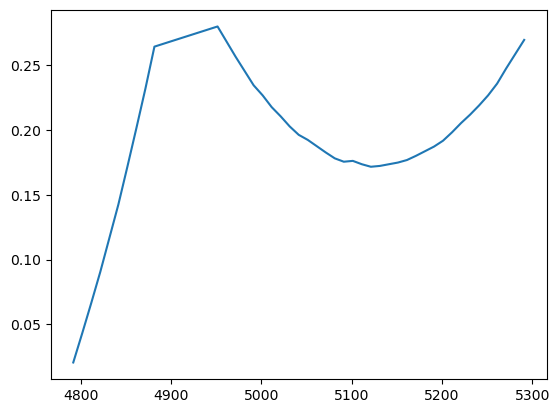

In [15]:
global path
csv_path = path + '.csv'

# create and populate csv instance
def make_csv(path, points):
    with open(path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['time', 'x_pos', 'y_pos'])
        for p in points:
            writer.writerow([p.delta / timedelta(milliseconds=1), p.real_pos[0], p.real_pos[1]])

# display plot
make_csv(csv_path, tracking_points)
df = pd.read_csv(csv_path)
plt.plot(df.time, df.y_pos)
df.head(5)

## TODO
better naming;
more use of macros/constants where possible;
make contour tracker;
csv writer;
import matplotlib fails first try after adding pandas